<a href="https://colab.research.google.com/github/AnupamaRajkumar/AppliedDeepLearning/blob/master/Object_%26_keypoint_detection_on_Cats_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2/B
**Disclaimer: Only for ADL/AML students!**

### General information
**You have to solve all tasks to pass!** 

Grade is calculated by the day of the last submission, but you will only get it after you've succesfully presented it. 

*Deadlines and grades:* 
  * 2020.10.27 - 2020.11.24 ==> 5
  * 2020.11.25 - 2020.12.01 ==> 4
  * 2020.12.02 - 2020.12.08 ==> 3
  * 2020.12.09 - 2020.12.15 ==> 2
  * 2020.12.16 or later ==> 1

### Description
In this assignment you have to build a Mask R-CNN based keypoint detector model using [Detectron2](https://github.com/facebookresearch/detectron2). Detectron2 was written in PyTorch and contains many state-of-the-art obejct detection models with pretrained weights. (*Don't worry, you don't have to use any PyTorch specific function, just the methods provided by the Detectron2 package.*) 

First, you have to preprocess and then convert the Cats Dataset to COCO format. After that, finetune a pretrained keypoint model (which was trained on COCO dataset) to predict cat keypoints. Finally, to see the results, run it on some videos.

**You can use this notebook for guidance: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5**

*__Optional:__ You can get better a better grade on one of your assignments, if you temporally extend this method. By matching the bounding boxes using Hungarian algorithm, you can create a simple tracking method without modifying the network. Here you can find a good explanation of how it works: https://towardsdatascience.com/computer-vision-for-tracking-8220759eee85 (It's enough to only implement the Hungarian matching part without using Kalman filter.)*  

### Use GPU
Runtime -> Change runtime type

At Hardware accelerator select  GPU then save it.  

### Useful shortcuts
* Run selected cell: *Ctrl + Enter*
* Insert cell below: *Ctrl + M B*
* Insert cell above: *Ctrl + M A*
* Convert to text: *Ctrl + M M*
* Split at cursor: *Ctrl + M -*
* Autocomplete: *Ctrl + Space* or *Tab*
* Move selected cells up: *Ctrl + M J*
* Move selected cells down: *Ctrl + M K*
* Delete selected cells: *Ctrl + M D*


### Tips
* **You may need to restart the notebook if the following cell returns some errors (red texts).**
* To prevent Google colab from disconnecting: https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0 

If you have any question, feel free to ask. 
kopacsi@inf.elte.hu

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 'pycocotools>=2.0.1'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

## Prepare dataset

* Download the Cats dataset. We will only use a subset of the original dataset, the CAT_00 folder. Here you can find more information about the dataset: https://www.kaggle.com/crawford/cat-dataset
* Preprocess the data. You can find some help here: https://github.com/kairess/cat_hipsterizer/blob/master/preprocess.py
  * Following the steps in the link above, read the images (don't resize them).
  * Keep only the left eye, right eye and mouth coordinates.
  * Generate bounding boxes by taking the min and max keypoint coordinates. *Note: Add +10 pixels to the max bounding box coordinates to include the entire head of the cat.*
* Split the dataset into train-test sets (ratio: 80-20), without shuffling, and print the size of each set.
* Convert the datasets to COCO format. Here you can find the format: https://detectron2.readthedocs.io/tutorials/datasets.html#standard-dataset-dicts 
  * You only need to use these fields: `file_name, height, width, image_id, annotations`.
  * Each `annotation` field should contain a list that contains a dictionary with the following keys: `bbox, bbox_mode, category_id, iscrowd, keypoints` (***Note #1**: the value of the `category_id` and the `iscrowd` should be 0. **Note #2**: After each keypoint you need to add a visibility flag too. The value of the visibility flag should be 2, as according to the documentation: all keypoints are labeled and visible.*)
* Finally, register the datasets and visualize some (e.g. 3) samples (randomly), to check that everything works fine.
  * You have to set the `MetadataCatalog` as well, see: https://detectron2.readthedocs.io/tutorials/datasets.html#metadata-for-datasets 
    * These `fields` should be specified: `thing_classes, keypoint_names, keypoint_flip_map, keypoint_connection_rules`.

In [ ]:
# Download from Drive
!if ! [ -f CAT_00.zip ]; then curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1wGwNi8t-UKAKs-LQL3dG-D8dzGVPHv2w" > /dev/null; curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1wGwNi8t-UKAKs-LQL3dG-D8dzGVPHv2w" -o CAT_00.zip; fi

# Check if the file size is correct (~402MB)
!if (( $(stat -c%s CAT_00.zip) < 421896648 )); then rm -rfd CAT_00.zip; fi

# If not, download it from NIPG12
!wget -nc -O CAT_00.zip http://nipg1.inf.elte.hu:8000/CAT_00.zip

In [ ]:
!unzip -o CAT_00.zip

## Try out the model
To test the model download the following image. Load the [pretrained R50-FPN 3x keypoint model](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-person-keypoint-detection-baselines-with-keypoint-r-cnn), evaluate it on the image, then visualize (plot) the result. 


In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg

## Training
* Initialize the model with pretrained weights: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-person-keypoint-detection-baselines-with-keypoint-r-cnn
* Set the training parameters:
```
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3
cfg.TEST.KEYPOINT_OKS_SIGMAS = [.079, .107, .089]
```
* Train the model. (*Note: To debug your code, you can reduce the MAX_ITER to 300.*)  


## Evaluation
* Evalute the model on the test set.
* Visualize some (e.g. 5) results.
* Run the model on the following videos:
  * https://www.youtube.com/watch?v=z3U0udLH974&ab_channel=TheCatsPyjaaaamas
  * https://www.youtube.com/watch?v=Y4z21xjv8KM&ab_channel=ONEMedia


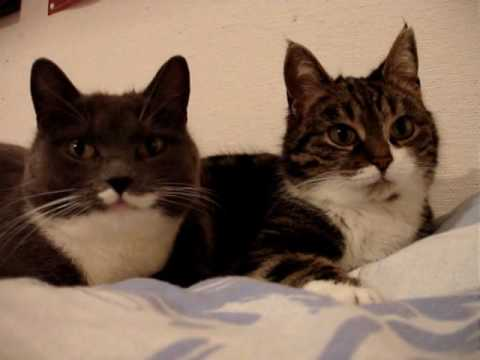

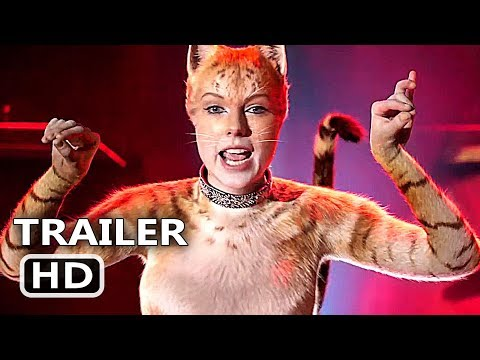

In [ ]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("z3U0udLH974", width=500)
display(video)
video = YouTubeVideo("Y4z21xjv8KM", width=500)
display(video)

Download the videos:

In [ ]:
!pip install youtube-dl
!pip uninstall -y opencv-python-headless opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues

!youtube-dl https://www.youtube.com/watch?v=z3U0udLH974&ab_channel=TheCatsPyjaaaamas
!mv 'The two talking cats-z3U0udLH974.mkv' video1.mkv
!youtube-dl https://www.youtube.com/watch?v=Y4z21xjv8KM&ab_channel=ONEMedia
!mv 'CATS Trailer # 2 (2019) Taylor Swift, Idris Elba Movie HD-Y4z21xjv8KM.webm' video2.webm

## Temporal extension (optional)
For more info see the description.